In [4]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt

2024-12-19 20:36:25.785934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 20:36:25.790819: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 20:36:25.805728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734651385.828747   49452 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734651385.836030   49452 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 20:36:25.859344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [28]:
!nvidia-smi

Thu Dec 19 20:52:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P5             15W /   30W |       7MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
print(f"Each image has the size {X_train.shape[1], X_train.shape[1]} and has {X_train.shape[0]} images")

Each image has the size (28, 28) and has 60000 images


In [7]:
def balancing(labels):
    value, count = np.unique(y_train, return_counts = True)
    for i in zip(value, count):
        print(f"val {i[0]} has {i[1]} samples.")
balancing(y_train)

val 0 has 5923 samples.
val 1 has 6742 samples.
val 2 has 5958 samples.
val 3 has 6131 samples.
val 4 has 5842 samples.
val 5 has 5421 samples.
val 6 has 5918 samples.
val 7 has 6265 samples.
val 8 has 5851 samples.
val 9 has 5949 samples.


In [5]:
type(y_train[0])

numpy.uint8

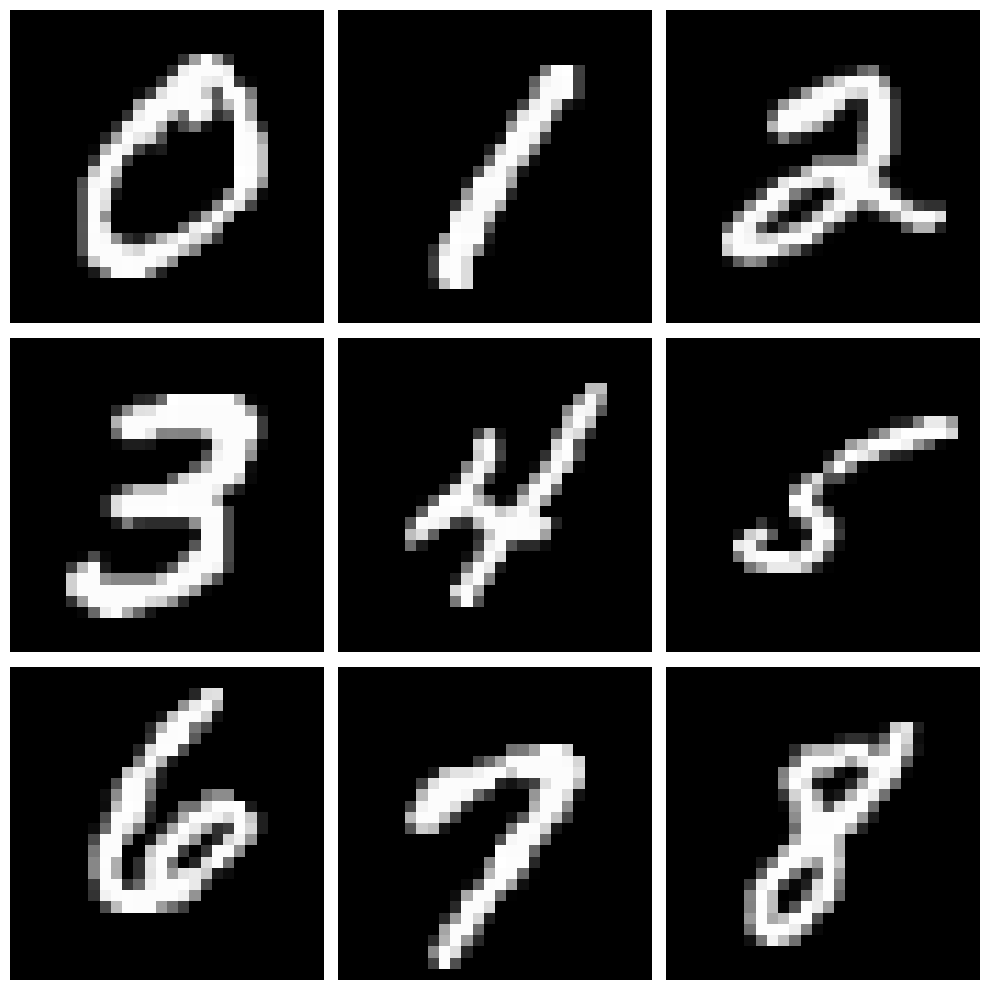

In [8]:
def show_images(data):
    lst = []  # To store unique labels
    plt.figure(figsize=(10, 10))  # Set figure size for the 3x3 grid
    prev = 0
    
    for i in range(data.shape[0]):
        if len(lst) >= 9:  # Display only the first 9 unique labels
            break
        if (data.iloc[i, -1] not in lst) and (data.iloc[i, -1] == prev):  # Check if the label is new
            prev += 1
            lst.append(data.iloc[i, -1])  # Add the new label to the list
            plt.subplot(3, 3, len(lst))  # Correct 3x3 grid position
            plt.imshow(data.iloc[i, 0], cmap='gray')  # Show the image
            plt.axis('off')  # Remove axis ticks

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show all images at once

# Example DataFrame (assuming X_train is a NumPy array and y_train is a list/array of labels)
data = pd.DataFrame({"data": list(X_train), "labels": y_train})  
show_images(data)


In [9]:
X_train[1, :].shape

(28, 28)

In [10]:
np.max(X_train[1, :])

np.uint8(255)

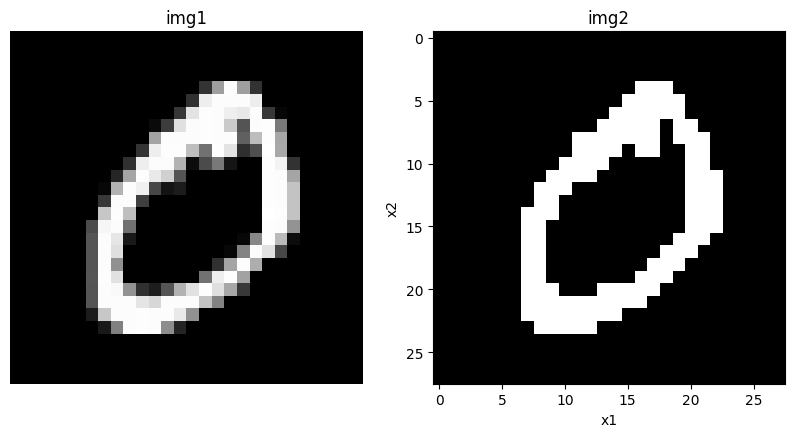

In [11]:
def binarization(img : np.ndarray):
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap = "gray")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("img1")
    plt.axis("off")
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] >= np.max(img) // 2:
                img[i, j] = np.max(img)
            else:
                img[i, j] = 0
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap = "gray")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("img2")
    plt.show()
                    
binarization(X_train[1, :])

In [12]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)


In [13]:
!pip install scikit-learn scipy

  Using cached scikit_learn-1.6.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [24]:
from sklearn.manifold import TSNE
from scipy.stats import skew, kurtosis

def compute_components(images):
    """
    Compute the components to apply the TSNE
    """
    std_ = np.zeros(images.shape[0])
    mean_ = np.zeros(images.shape[0])
    skew_ = np.zeros(images.shape[0])
    kurto_ = np.zeros(images.shape[0])
    for count, img in enumerate(images):
        std_[count] = np.std(img)
        mean_[count] = np.mean(img)
        skew_[count] = skew(img.flatten())
        kurto_[count] = kurtosis(img.flatten())

    return std_, mean_, skew_, kurto_

In [25]:
x_train_norm = X_train / 255.0  # Ensure normalization

std_, mean_, skew_, kurto_ = compute_components(x_train_norm)

In [29]:
arr_ = np.concatenate((std_.reshape(-1, 1), mean_.reshape(-1, 1), skew_.reshape(-1, 1), kurto_.reshape(-1, 1)), axis = 1)
print(f"The array has {arr_.shape} dimensions.")

The array has (60000, 4) dimensions.


In [36]:
%%time

TSNE = TSNE(n_components = 2, learning_rate = "auto", init = "random", perplexity = 45)
x_tsne = TSNE.fit_transform(arr_)

CPU times: user 12min 33s, sys: 12.4 s, total: 12min 45s
Wall time: 3min 1s


In [38]:
print(f"The array returned has the shape : {x_tsne.shape}")

The array returned has the shape : (60000, 2)


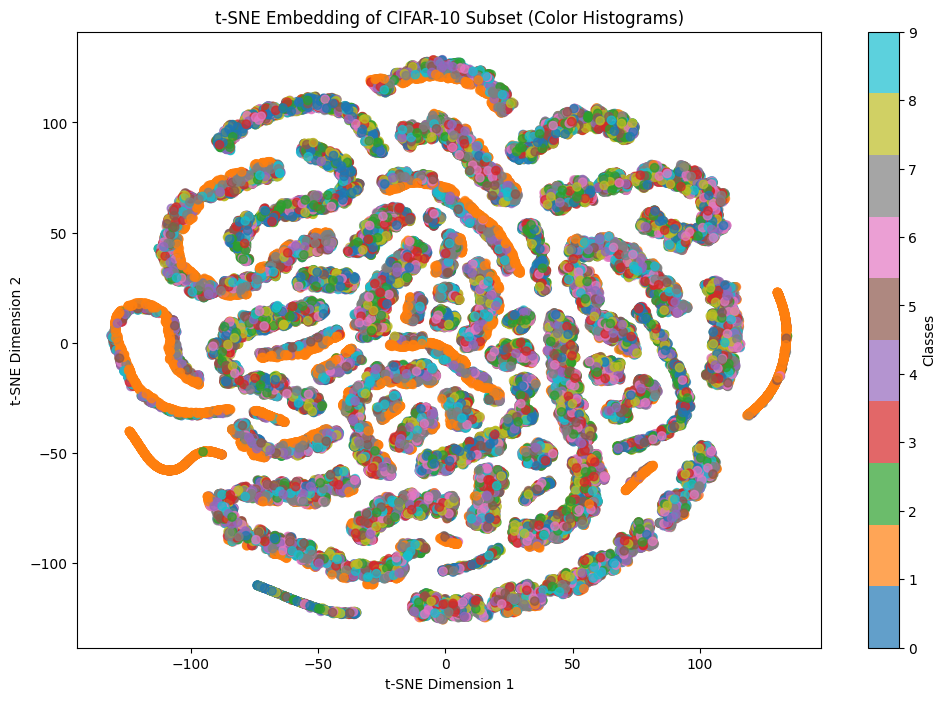

In [41]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c = y_train.flatten(), cmap="tab10", alpha=0.7)
plt.colorbar(scatter, ticks=range(len(labels)), label='Classes')
plt.title("t-SNE Embedding of CIFAR-10 Subset (Color Histograms)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

#### Applying PCA

In [46]:
%%time
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
x_pca = pca.fit_transform(arr_)

CPU times: user 7.41 ms, sys: 2.01 ms, total: 9.41 ms
Wall time: 6.94 ms


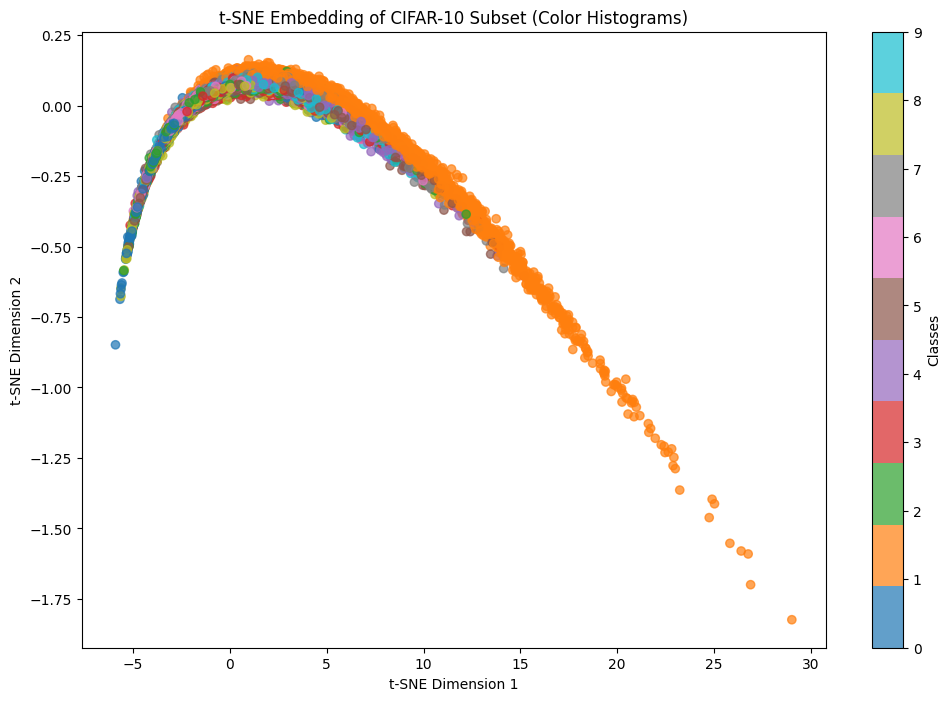

In [48]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c = y_train.flatten(), cmap="tab10", alpha=0.7)
plt.colorbar(scatter, ticks=range(len(labels)), label='Classes')
plt.title("t-SNE Embedding of CIFAR-10 Subset (Color Histograms)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()